# 00-EDA: Exploratory Data Analysis
*Loading Lending Club data and inspecting key fields.*

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import hvplot.pandas  
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
!pip freeze > requirements.txt

In [4]:
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/loan.csv')
df

/tmp/ipython-input-7-1669866883.py:1: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/loan.csv')


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.000,36 months,13.560,84.920,C,C1,Chef,10+ years,RENT,55000.000,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.240,0.000,Apr-2001,1.000,NaN,45.000,9.000,1.000,4341,10.300,34.000,w,2386.020,2386.020,167.020,167.020,113.980,53.040,0.000,0.000,0.000,Feb-2019,84.920,Mar-2019,Feb-2019,0.000,NaN,1,Individual,NaN,NaN,NaN,0.000,0.000,16901.000,2.000,2.000,1.000,2.000,2.000,12560.000,69.000,2.000,7.000,2137.000,28.000,42000.000,1.000,11.000,2.000,9.000,1878.000,34360.000,5.900,0.000,0.000,140.000,212.000,1.000,1.000,0.000,1.000,NaN,2.000,NaN,0.000,2.000,5.000,3.000,3.000,16.000,7.000,18.000,5.000,9.000,0.000,0.000,0.000,3.000,100.000,0.000,1.000,0.000,60124.000,16901.000,36500.000,18124.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.000,60 months,18.940,777.230,D,D2,Postmaster,10+ years,MORTGAGE,90000.000,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.520,0.000,Jun-1987,0.000,71.000,75.000,13.000,1.000,12315,24.200,44.000,w,29387.750,29387.750,1507.110,1507.110,612.250,894.860,0.000,0.000,0.000,Feb-2019,777.230,Mar-2019,Feb-2019,0.000,NaN,1,Individual,NaN,NaN,NaN,0.000,1208.000,321915.000,4.000,4.000,2.000,3.000,3.000,87153.000,88.000,4.000,5.000,998.000,57.000,50800.000,2.000,15.000,2.000,10.000,24763.000,13761.000,8.300,0.000,0.000,163.000,378.000,4.000,3.000,3.000,4.000,NaN,4.000,NaN,0.000,2.000,4.000,4.000,9.000,27.000,8.000,14.000,4.000,13.000,0.000,0.000,0.000,6.000,95.000,0.000,1.000,0.000,372872.000,99468.000,15000.000,94072.000,NaN,NaN,NaN,N

In [8]:
dfc= df.copy()

1. Dataset Overview

In [9]:
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,url,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.000,0.000,2260668.000,2260668.000,2260668.000,2260668.000,2260668.000,2260664.000,0.000,2258957.000,2260639.000,2260638.000,1102166.000,359156.000,2260639.000,2260639.000,2260668.000,2258866.000,2260639.000,2260668.000,2260668.000,2260668.000,2260668.000,2260668.000,2260668.000,2260668.000,2260668.000,2260668.000,2260668.000,2260523.000,580775.000,2260668.000,120710.000,120706.000,2260639.000,2190392.000,2190392.000,1394538.000,1394539.000,1394539.000,1394539.000,1350744.000,1394539.000,1191818.000,1394539.000,1394539.000,1394539.000,1394320.000,2190392.000,1394539.000,1394538.000,1394538.000,2210638.000,2190322.000,2185733.000,2184597.000,2260523.000,2260639.000,2121597.000,2190391.000,2190391.000,2190392.000,2210638.000,2187256.000,519701.000,1965233.000,740359.000,2190392.000,2190392.000,2190392.000,2202078.000,2190392.000,2190392.000,2190392.000,2190391.000,2190392.000,2202078.000,2107011.000,2190392.000,2190392.000,2190392.000,2190237.000,2185289.000,2259303.000,2260563.000,2190392.000,2210638.000,2210638.000,2190392.000,108020.000,108021.000,108021.000,108021.000,106184.000,108021.000,108021.000,108021.000,108021.000,35942.000,10613.000,10613.000,10613.000,10613.000,8426.000,10613.000,10613.000,33056.000,33056.000,33056.000
mean,NaN,NaN,15046.931,15041.664,15023.438,13.093,445.808,77992.429,NaN,18.824,0.307,0.577,34.541,72.313,11.612,0.198,16658.458,50.338,24.163,4446.293,4445.295,11824.030,11805.944,9300.142,2386.352,1.462,136.074,22.593,3364.015,0.018,44.164,1.000,123624.637,19.252,0.004,232.732,142492.195,0.934,2.779,0.676,1.563,21.222,35506.645,69.141,1.290,2.750,5806.393,57.032,34573.943,1.013,1.477,2.037,4.522,13547.798,11394.263,57.900,0.008,12.370,125.738,181.492,14.024,8.297,1.555,24.845,39.303,7.024,35.782,0.500,3.676,5.629,4.774,7.726,8.413,8.247,14.005,5.578,11.628,0.001,0.003,0.083,2.077,94.115,42.435,0.128,0.047,178242.754,51022.938,23193.768,43732.013,33617.279,0.633,1.539,11.469,58.169,3.011,12.533,0.046,0.078,36.938,3.000,155.007,3.000,13.686,454.841,11628.036,193.606,5030.607,47.776,13.149
std,NaN,NaN,9190.245,9188.413,9192.332,4.832,267.174,112696.200,NaN,14.183,0.867,0.886,21.900,26.464,5.641,0.571,22948.305,24.713,11.988,7547.612,7546.657,9889.599,9884.835,8304.88

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


In [11]:
# List of columns to delete (columns that wont impact the score)
cols_to_delete = [
    'id', 'member_id', 'url', 'desc', 'pymnt_plan', 'next_pymnt_d',
    'last_pymnt_d', 'last_credit_pull_d', 'out_prncp', 'out_prncp_inv',
    'total_pymnt', 'total_pymnt_inv', 'recoveries', 'collection_recovery_fee',
    'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status',
    'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date',
    'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status',
    'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount',
    'hardship_last_payment_amount', 'debt_settlement_flag', 'debt_settlement_flag_date',
    'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage',
    'settlement_term', 'policy_code', 'disbursement_method'
]

# Delete columns from DataFrame
df = df.drop(columns=cols_to_delete, errors='ignore')

2. Target Variable Analysis

In [12]:
df['loan_status'].unique()

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'In Grace Period',
       'Charged Off', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [ ]:
#converting loan_status into binary values
good_statuses = [
    'Fully Paid',
    'Current',
    'Does not meet the credit policy. Status:Fully Paid'
]

# All others are considered "bad"
df['loan_status_binary'] = df['loan_status'].apply(lambda x: 0 if x in good_statuses else 1)


In [ ]:
# target class balance
loan_binary_counts = df['loan_status_binary'].value_counts()
loan_binary_percentage = df['loan_status_binary'].value_counts(normalize=True) * 100

print("\nBinary Loan Status Distribution:")
for status, count in loan_binary_counts.items():
    status_name = "Good Loan" if status == 0 else "Bad Loan"
    print(f"{status_name}: {count} ({loan_binary_percentage[status]:.2f}%)")


Binary Loan Status Distribution:
Good Loan: 1963635 (86.86%)
Bad Loan: 297033 (13.14%)


In [ ]:
# class imbalance ratio
imbalance_ratio = loan_binary_counts[0] / loan_binary_counts[1]
print(f"\nClass imbalance ratio (Good:Bad): {imbalance_ratio:.2f}:1")


Class imbalance ratio (Good:Bad): 6.61:1


In [16]:
df['loan_status_binary'].value_counts().hvplot.bar(
    title="Loan Status Counts", xlabel='Loan Status', ylabel='Count',
    width=500, height=350
)

:Bars   [loan_status_binary]   (count)

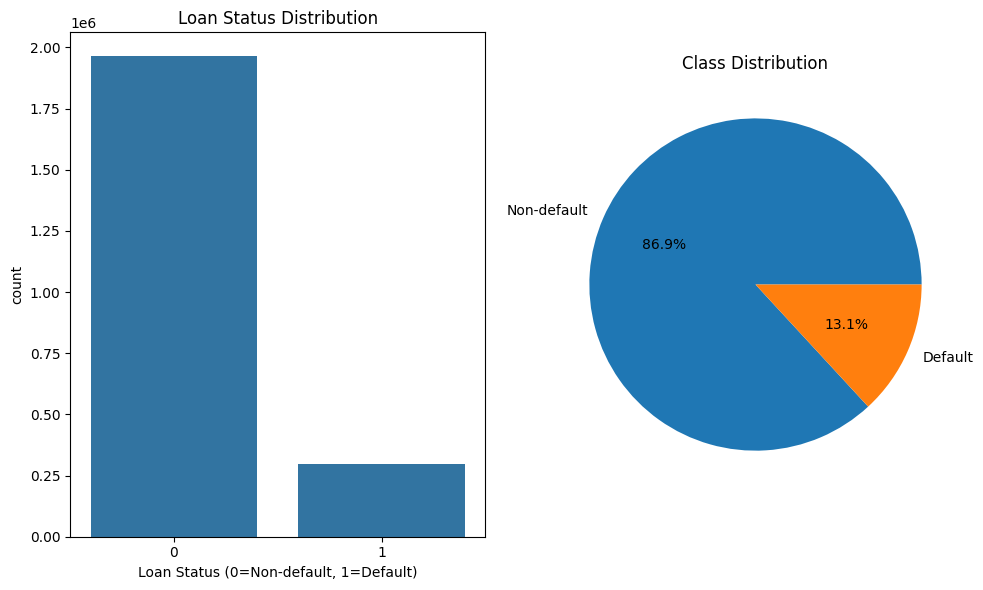

In [17]:
# Target variable distribution
plt.figure(figsize=(10, 6))
target_counts = df['loan_status_binary'].value_counts()
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='loan_status_binary')
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status (0=Non-default, 1=Default)')

plt.subplot(1, 2, 2)
plt.pie(target_counts.values, labels=['Non-default', 'Default'], autopct='%1.1f%%')
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

3. Missing Values Analysis

In [ ]:
# column summary
column_summary = pd.DataFrame({
    'DataType': df.dtypes,
    'MissingCount': df.isnull().sum(),
    'MissingPercentage': (df.isnull().sum() / len(df)) * 100
}).sort_values('MissingCount', ascending=False)

column_summary.reset_index(inplace=True)
column_summary.rename(columns={'index': 'Column'}, inplace=True)

print(column_summary)

                                  Column DataType  MissingCount  \
0    sec_app_mths_since_last_major_derog  float64       2224726   
1                     sec_app_revol_util  float64       2154484   
2                        revol_bal_joint  float64       2152648   
3                       sec_app_open_acc  float64       2152647   
4                       sec_app_mort_acc  float64       2152647   
5               sec_app_earliest_cr_line   object       2152647   
6                    sec_app_open_act_il  float64       2152647   
7                 sec_app_inq_last_6mths  float64       2152647   
8                  sec_app_num_rev_accts  float64       2152647   
9       sec_app_chargeoff_within_12_mths  float64       2152647   
10    sec_app_collections_12_mths_ex_med  float64       2152647   
11             verification_status_joint   object       2144938   
12                             dti_joint  float64       2139962   
13                      annual_inc_joint  float64       213995

In [19]:
#dropping columns with more than 30 percent values to be null
threshold = 0.3  # 30% threshold
missing_fraction = df.isnull().mean()
cols_to_drop = missing_fraction[missing_fraction > threshold].index
df = df.drop(columns=cols_to_drop)

In [20]:
df.shape

(2260668, 75)

In [ ]:
# Map 'term' from string to integer
df['term'] = df['term'].str.extract('(\d+)').astype(float)

# Map 'grade' from A-G to ordinal integers
grade_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
df['grade'] = df['grade'].map(grade_map)

# Label encode 'sub_grade'
df['sub_grade']= df['sub_grade'].map({'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3, 'A5': 4,
                                      'B1': 5, 'B2': 6, 'B3': 7, 'B4': 8, 'B5': 9,
                                      'C1': 10, 'C2': 11, 'C3': 12, 'C4': 13, 'C5': 14,
                                      'D1': 15, 'D2': 16, 'D3': 17, 'D4': 18, 'D5': 19,
                                      'E1': 20, 'E2': 21, 'E3': 22, 'E4': 23, 'E5': 24,
                                      'F1': 25, 'F2': 26, 'F3': 27, 'F4': 28, 'F5': 29,
                                      'G1': 30, 'G2': 31, 'G3': 32, 'G4': 33, 'G5': 34})

# Convert 'issue_d' to datetime
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')

# Drop 'emp_title' and 'title'
df.drop(columns=['emp_title', 'title'], inplace=True)

# Convert 'earliest_cr_line' to datetime and extract credit history length
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')
df['credit_history_length'] = df['issue_d'].dt.year - df['earliest_cr_line'].dt.year


In [ ]:
# Cleaning the emp_length values
df['emp_length'] = df['emp_length'].str.replace(r'\+ years', '', regex=True)
df['emp_length'] = df['emp_length'].str.replace(r' years', '', regex=True)
df['emp_length'] = df['emp_length'].str.replace(r' year', '', regex=True)
df['emp_length'] = df['emp_length'].str.replace(r'< 1', '0')
df['emp_length'] = df['emp_length'].replace('n/a', np.nan)

# Converting them to numeric
df['emp_length'] = pd.to_numeric(df['emp_length'], errors='coerce')

In [23]:
def fix_very_low_missing(df):
    cols_to_fix = {
        'annual_inc': 'median',
        'zip_code': 'mode',
        'inq_last_6mths': 'median',
        'delinq_amnt': 'median',
        'pub_rec': 'median',
        'delinq_2yrs': 'median',
        'earliest_cr_line': 'mode',
        'open_acc': 'median',
        'acc_now_delinq': 'median',
        'total_acc': 'median'
    }
    for col, method in cols_to_fix.items():
        if col in df.columns and df[col].isnull().sum() > 0:
            value = df[col].median() if method == 'median' else df[col].mode()[0]
            df[col].fillna(value, inplace=True)
    return df


In [24]:
def fix_low_missing(df):
    zero_fill = [
        'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'tax_liens'
    ]

    median_fill = [
        'revol_util', 'dti', 'pub_rec_bankruptcies',
        'mort_acc', 'acc_open_past_24mths', 'total_bc_limit', 'total_bal_ex_mort',
        'num_bc_sats', 'num_sats'
    ]

    mode_fill = ['title']

    for col in zero_fill:
        if col in df.columns and df[col].isnull().sum() > 0:
            df[col].fillna(0, inplace=True)

    for col in median_fill:
        if col in df.columns and df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)

    for col in mode_fill:
        if col in df.columns and df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)

    return df


In [25]:
def fix_moderate_missing(df):
    moderate_cols = [
        'num_tl_120dpd_2m', 'mo_sin_old_il_acct', 'bc_util',
        'percent_bc_gt_75', 'bc_open_to_buy', 'mths_since_recent_bc',
        'pct_tl_nvr_dlq', 'avg_cur_bal', 'mo_sin_rcnt_rev_tl_op',
        'mo_sin_old_rev_tl_op', 'num_rev_accts', 'tot_cur_bal',
        'total_rev_hi_lim', 'mo_sin_rcnt_tl', 'num_actv_bc_tl',
        'num_actv_rev_tl', 'num_il_tl', 'num_bc_tl', 'num_rev_tl_bal_gt_0',
        'num_op_rev_tl', 'num_tl_90g_dpd_24m','tot_hi_cred_lim', 'num_tl_30dpd',
        'tot_coll_amt', 'num_accts_ever_120_pd',
        'total_il_high_credit_limit', 'num_tl_op_past_12m'
    ]

    for col in moderate_cols:
        if col in df.columns and df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)

    return df


In [26]:
def fix_high_missing(df):
    if 'mths_since_recent_inq' in df.columns and df['mths_since_recent_inq'].isnull().sum() > 0:
        df['mths_since_recent_inq'].fillna(999, inplace=True)

    if 'emp_title' in df.columns and df['emp_title'].isnull().sum() > 0:
        df['emp_title'].fillna('Not Provided', inplace=True)

    return df


In [27]:
df = fix_very_low_missing(df)
df = fix_low_missing(df)
df = fix_moderate_missing(df)
df = fix_high_missing(df)

/tmp/ipython-input-23-2951128834.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(value, inplace=True)
/tmp/ipython-input-23-2951128834.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

In [28]:
# Fill emp_length with median (since it's ordinal)
df['emp_length'].fillna(df['emp_length'].median(), inplace=True)

# Fill credit_history_length with median (tiny missing, safe)
df['credit_history_length'].fillna(df['credit_history_length'].median(), inplace=True)


/tmp/ipython-input-28-151640255.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['emp_length'].fillna(df['emp_length'].median(), inplace=True)
/tmp/ipython-input-28-151640255.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

In [29]:
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_summary = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percent
}).sort_values('Missing_Percentage', ascending=False)

print(missing_summary[missing_summary.Missing_Count > 0])

Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []


In [30]:
df.to_csv('Preprocessing_Loan_CSV.csv', index=False)


In [37]:
from google.colab import files
files.download('Preprocessing_Loan_CSV.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>